In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### ESC-50 Data

In [18]:
from data.constants import ESC_50, ESC_50_META
from data.esc_50 import load_esc_data

In [19]:
df = pd.read_csv(os.path.join(ESC_50_META,'esc50.csv'))

In [4]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

wav, sr = librosa.load(os.path.join(ESC_50,'audio/1-100032-A-0.wav'), sr=None)

In [20]:
train_loader, test_loader, _ = load_esc_data(ESC_50, ESC_50_META)

100%|██████████| 400/400 [00:06<00:00, 62.34it/s]


### FSD Data

In [2]:
from data.fsd_kaggle_2018 import load_fsd_data
from data.constants import FSD_META, FSD_TEST, FSD_TRAIN

train_loader, test_loader, _ = load_fsd_data(FSD_META, FSD_TRAIN, FSD_TEST)

100%|██████████| 1600/1600 [00:31<00:00, 51.52it/s]


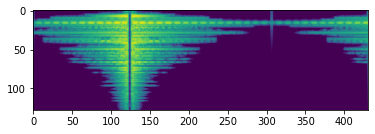

In [10]:
wv, y = next(iter(train_loader))
plt.imshow(wv[0,:,:,:].permute(1,2,0))

### Training

In [11]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [12]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    # model.eval()
    # batch_losses=[]
    # trace_y = []
    # trace_yhat = []
    # for i, data in enumerate(valid_loader):
    #   x, y = data
    #   x = x.to(device, dtype=torch.float32)
    #   y = y.to(device, dtype=torch.long)
    #   y_hat = model(x)
    #   loss = loss_fn(y_hat, y)
    #   trace_y.append(y.cpu().detach().numpy())
    #   trace_yhat.append(y_hat.cpu().detach().numpy())      
    #   batch_losses.append(loss.item())
    # valid_losses.append(batch_losses)
    # trace_y = np.concatenate(trace_y)
    # trace_yhat = np.concatenate(trace_yhat)
    # accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    # print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [13]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [14]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

imagenet_weights = resnet_model.state_dict()

C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training ESC-50

In [10]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, test_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  2%|▏         | 1/50 [00:02<01:59,  2.44s/it]

Epoch - 1 Train-Loss : 2.5949853658676147


  4%|▍         | 2/50 [00:03<01:30,  1.88s/it]

Epoch - 2 Train-Loss : 0.954962944984436


  6%|▌         | 3/50 [00:05<01:19,  1.70s/it]

Epoch - 3 Train-Loss : 0.39481127619743345


  8%|▊         | 4/50 [00:06<01:14,  1.61s/it]

Epoch - 4 Train-Loss : 0.2116078895330429


 10%|█         | 5/50 [00:08<01:10,  1.57s/it]

Epoch - 5 Train-Loss : 0.12301352918148041


 12%|█▏        | 6/50 [00:09<01:07,  1.54s/it]

Epoch - 6 Train-Loss : 0.08848853200674058


 14%|█▍        | 7/50 [00:11<01:05,  1.53s/it]

Epoch - 7 Train-Loss : 0.05024482652544975


 16%|█▌        | 8/50 [00:12<01:03,  1.52s/it]

Epoch - 8 Train-Loss : 0.05660188522189855


 18%|█▊        | 9/50 [00:14<01:01,  1.51s/it]

Epoch - 9 Train-Loss : 0.09430524080991745
Changed learning rate to 2e-05


 20%|██        | 10/50 [00:15<01:00,  1.51s/it]

Epoch - 10 Train-Loss : 0.054761564284563066


 22%|██▏       | 11/50 [00:17<00:59,  1.53s/it]

Epoch - 11 Train-Loss : 0.01944695062935352


 24%|██▍       | 12/50 [00:19<00:58,  1.55s/it]

Epoch - 12 Train-Loss : 0.01565154332667589


 26%|██▌       | 13/50 [00:20<00:57,  1.56s/it]

Epoch - 13 Train-Loss : 0.013743073232471942


 28%|██▊       | 14/50 [00:22<00:55,  1.54s/it]

Epoch - 14 Train-Loss : 0.010488031525164842


 30%|███       | 15/50 [00:23<00:54,  1.54s/it]

Epoch - 15 Train-Loss : 0.01017009699717164


 32%|███▏      | 16/50 [00:25<00:52,  1.55s/it]

Epoch - 16 Train-Loss : 0.009562464728951454


 34%|███▍      | 17/50 [00:26<00:51,  1.56s/it]

Epoch - 17 Train-Loss : 0.009079367462545633


 36%|███▌      | 18/50 [00:28<00:49,  1.55s/it]

Epoch - 18 Train-Loss : 0.008425898887217044


 38%|███▊      | 19/50 [00:29<00:48,  1.56s/it]

Epoch - 19 Train-Loss : 0.00807079141959548
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:31<00:47,  1.57s/it]

Epoch - 20 Train-Loss : 0.007387906480580568


 42%|████▏     | 21/50 [00:33<00:45,  1.56s/it]

Epoch - 21 Train-Loss : 0.008745947368443013


 44%|████▍     | 22/50 [00:34<00:43,  1.55s/it]

Epoch - 22 Train-Loss : 0.007228256575763226


 46%|████▌     | 23/50 [00:36<00:41,  1.53s/it]

Epoch - 23 Train-Loss : 0.008098201658576727


 48%|████▊     | 24/50 [00:37<00:39,  1.53s/it]

Epoch - 24 Train-Loss : 0.007438281122595072


 50%|█████     | 25/50 [00:39<00:38,  1.54s/it]

Epoch - 25 Train-Loss : 0.0069126787409186366


 52%|█████▏    | 26/50 [00:40<00:36,  1.54s/it]

Epoch - 26 Train-Loss : 0.007291472535580396


 54%|█████▍    | 27/50 [00:42<00:35,  1.54s/it]

Epoch - 27 Train-Loss : 0.006805010810494423


 56%|█████▌    | 28/50 [00:43<00:33,  1.53s/it]

Epoch - 28 Train-Loss : 0.007183325570076704


 58%|█████▊    | 29/50 [00:45<00:32,  1.53s/it]

Epoch - 29 Train-Loss : 0.007122603971511126
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [00:46<00:30,  1.52s/it]

Epoch - 30 Train-Loss : 0.007243861854076386


 62%|██████▏   | 31/50 [00:48<00:28,  1.52s/it]

Epoch - 31 Train-Loss : 0.00696194713935256


 64%|██████▍   | 32/50 [00:49<00:27,  1.53s/it]

Epoch - 32 Train-Loss : 0.007051364127546549


 66%|██████▌   | 33/50 [00:51<00:25,  1.53s/it]

Epoch - 33 Train-Loss : 0.007200423441827297


 68%|██████▊   | 34/50 [00:52<00:24,  1.53s/it]

Epoch - 34 Train-Loss : 0.007311937399208546


 70%|███████   | 35/50 [00:54<00:22,  1.53s/it]

Epoch - 35 Train-Loss : 0.007079311739653349


 72%|███████▏  | 36/50 [00:55<00:21,  1.52s/it]

Epoch - 36 Train-Loss : 0.006522749420255423


 74%|███████▍  | 37/50 [00:57<00:19,  1.52s/it]

Epoch - 37 Train-Loss : 0.007143168468028307


 76%|███████▌  | 38/50 [00:58<00:18,  1.52s/it]

Epoch - 38 Train-Loss : 0.006561646889895201


 78%|███████▊  | 39/50 [01:00<00:16,  1.53s/it]

Epoch - 39 Train-Loss : 0.006571037787944078
Changed learning rate to 2e-08


 80%|████████  | 40/50 [01:02<00:15,  1.53s/it]

Epoch - 40 Train-Loss : 0.006767106913030147


 82%|████████▏ | 41/50 [01:03<00:13,  1.53s/it]

Epoch - 41 Train-Loss : 0.0068353600986301895


 84%|████████▍ | 42/50 [01:05<00:12,  1.53s/it]

Epoch - 42 Train-Loss : 0.007804343067109584


 86%|████████▌ | 43/50 [01:06<00:10,  1.52s/it]

Epoch - 43 Train-Loss : 0.006656852178275585


 88%|████████▊ | 44/50 [01:08<00:09,  1.53s/it]

Epoch - 44 Train-Loss : 0.0071149740181863305


 90%|█████████ | 45/50 [01:09<00:07,  1.53s/it]

Epoch - 45 Train-Loss : 0.007133069941774011


 92%|█████████▏| 46/50 [01:11<00:06,  1.52s/it]

Epoch - 46 Train-Loss : 0.006973836496472359


 94%|█████████▍| 47/50 [01:12<00:04,  1.52s/it]

Epoch - 47 Train-Loss : 0.007067699879407883


 96%|█████████▌| 48/50 [01:14<00:03,  1.52s/it]

Epoch - 48 Train-Loss : 0.00690194271504879


 98%|█████████▊| 49/50 [01:15<00:01,  1.51s/it]

Epoch - 49 Train-Loss : 0.00773402662947774
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:17<00:00,  1.54s/it]

Epoch - 50 Train-Loss : 0.007148805130273103


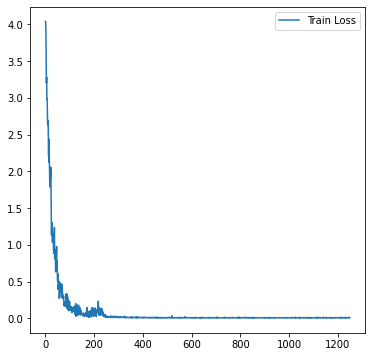

In [12]:


tl = np.asarray(resnet_train_losses).ravel()
# vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(6,6))
# plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
# plt.subplot(1,2,2)
# plt.plot(vl,'orange')
# plt.legend(['Valid Loss'])



In [15]:
with open(os.path.join("C:/Users/lenna/Documents/UvA/FACT/post-hoc-cbm/conceptbanks",'esc50resnet34.pth'),'wb') as f:
  torch.save(resnet_model, f)

In [24]:
def eval(model, validation_loader):
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for i, vdata in enumerate(validation_loader):
            x, y = vdata
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    acc = float(num_correct)/float(num_samples)*100
    print(f"test_acc: {acc:.2f}")
    return acc

eval(resnet_model, test_loader)

test_acc: 3.00


3.0

In [27]:
accs = []
for i in range(6,11):
    torch.random.manual_seed(i)
    resnet_model.load_state_dict(imagenet_weights)
    optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
    train(resnet_model, loss_fn, train_loader, test_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)
    test_acc = eval(resnet_model, test_loader)
    accs.append(test_acc)

print(f"Mean: {np.mean(accs)},\t+- {np.std(accs)}")

  2%|▏         | 1/50 [00:01<01:30,  1.84s/it]

Epoch - 1 Train-Loss : 0.017738134694081965


  4%|▍         | 2/50 [00:03<01:19,  1.65s/it]

Epoch - 2 Train-Loss : 0.033270285977632735


  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

Epoch - 3 Train-Loss : 0.023740221501793713


  8%|▊         | 4/50 [00:06<01:11,  1.56s/it]

Epoch - 4 Train-Loss : 0.035845153089612725


 10%|█         | 5/50 [00:07<01:08,  1.53s/it]

Epoch - 5 Train-Loss : 0.03819120756816119


 12%|█▏        | 6/50 [00:09<01:05,  1.50s/it]

Epoch - 6 Train-Loss : 0.020059475296875462


 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it]

Epoch - 7 Train-Loss : 0.011843510058242827


 16%|█▌        | 8/50 [00:12<01:01,  1.46s/it]

Epoch - 8 Train-Loss : 0.009222219960065559


 18%|█▊        | 9/50 [00:13<00:59,  1.45s/it]

Epoch - 9 Train-Loss : 0.0041955756148672665
Changed learning rate to 2e-05


 20%|██        | 10/50 [00:15<00:57,  1.45s/it]

Epoch - 10 Train-Loss : 0.0023954706569202246


 22%|██▏       | 11/50 [00:16<00:56,  1.45s/it]

Epoch - 11 Train-Loss : 0.00032494725164724516


 24%|██▍       | 12/50 [00:17<00:55,  1.45s/it]

Epoch - 12 Train-Loss : 0.0004278133957996033


 26%|██▌       | 13/50 [00:19<00:53,  1.44s/it]

Epoch - 13 Train-Loss : 0.001750405293132644


 28%|██▊       | 14/50 [00:20<00:51,  1.43s/it]

Epoch - 14 Train-Loss : 0.000404304327967111


 30%|███       | 15/50 [00:22<00:49,  1.43s/it]

Epoch - 15 Train-Loss : 0.0003682779043447226


 32%|███▏      | 16/50 [00:23<00:48,  1.42s/it]

Epoch - 16 Train-Loss : 0.0005455075037025381


 34%|███▍      | 17/50 [00:25<00:46,  1.42s/it]

Epoch - 17 Train-Loss : 0.0004489849301171489


 36%|███▌      | 18/50 [00:26<00:45,  1.42s/it]

Epoch - 18 Train-Loss : 0.00026344429177697746


 38%|███▊      | 19/50 [00:27<00:44,  1.42s/it]

Epoch - 19 Train-Loss : 0.0006130872706125956
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:29<00:42,  1.42s/it]

Epoch - 20 Train-Loss : 0.0002826020687643904


 42%|████▏     | 21/50 [00:30<00:41,  1.42s/it]

Epoch - 21 Train-Loss : 0.0002857620423310436


 44%|████▍     | 22/50 [00:32<00:39,  1.42s/it]

Epoch - 22 Train-Loss : 0.0003279424784705043


 46%|████▌     | 23/50 [00:33<00:38,  1.42s/it]

Epoch - 23 Train-Loss : 0.00032023215637309475


 48%|████▊     | 24/50 [00:34<00:36,  1.42s/it]

Epoch - 24 Train-Loss : 0.00021083193249069154


 50%|█████     | 25/50 [00:36<00:35,  1.42s/it]

Epoch - 25 Train-Loss : 0.0003416230571747292


 52%|█████▏    | 26/50 [00:37<00:34,  1.42s/it]

Epoch - 26 Train-Loss : 0.00039459096762584523


 54%|█████▍    | 27/50 [00:39<00:32,  1.42s/it]

Epoch - 27 Train-Loss : 0.00029443364259350345


 56%|█████▌    | 28/50 [00:40<00:31,  1.42s/it]

Epoch - 28 Train-Loss : 0.00031771184061653914


 58%|█████▊    | 29/50 [00:42<00:29,  1.42s/it]

Epoch - 29 Train-Loss : 0.0002449573745252565
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [00:43<00:28,  1.42s/it]

Epoch - 30 Train-Loss : 0.00022962940551224164


 62%|██████▏   | 31/50 [00:44<00:26,  1.42s/it]

Epoch - 31 Train-Loss : 0.0002197262791742105


 64%|██████▍   | 32/50 [00:46<00:25,  1.42s/it]

Epoch - 32 Train-Loss : 0.0001452012731169816


 66%|██████▌   | 33/50 [00:47<00:24,  1.42s/it]

Epoch - 33 Train-Loss : 0.0005435129870602395


 68%|██████▊   | 34/50 [00:49<00:22,  1.42s/it]

Epoch - 34 Train-Loss : 0.00019085642648860812


 70%|███████   | 35/50 [00:50<00:21,  1.42s/it]

Epoch - 35 Train-Loss : 0.0002491319834371097


 72%|███████▏  | 36/50 [00:51<00:19,  1.42s/it]

Epoch - 36 Train-Loss : 0.00027502850178279915


 74%|███████▍  | 37/50 [00:53<00:18,  1.42s/it]

Epoch - 37 Train-Loss : 0.000280502644891385


 76%|███████▌  | 38/50 [00:54<00:17,  1.42s/it]

Epoch - 38 Train-Loss : 0.0003216483275173232


 78%|███████▊  | 39/50 [00:56<00:15,  1.42s/it]

Epoch - 39 Train-Loss : 0.00033984055349719713
Changed learning rate to 2e-08


 80%|████████  | 40/50 [00:57<00:14,  1.42s/it]

Epoch - 40 Train-Loss : 0.00034094079019268974


 82%|████████▏ | 41/50 [00:59<00:12,  1.42s/it]

Epoch - 41 Train-Loss : 0.0002323381890892051


 84%|████████▍ | 42/50 [01:00<00:11,  1.42s/it]

Epoch - 42 Train-Loss : 0.00021178043520194478


 86%|████████▌ | 43/50 [01:01<00:09,  1.42s/it]

Epoch - 43 Train-Loss : 0.00020821448881179095


 88%|████████▊ | 44/50 [01:03<00:08,  1.42s/it]

Epoch - 44 Train-Loss : 0.00021460165808093735


 90%|█████████ | 45/50 [01:04<00:07,  1.42s/it]

Epoch - 45 Train-Loss : 0.00033823864650912584


 92%|█████████▏| 46/50 [01:06<00:05,  1.42s/it]

Epoch - 46 Train-Loss : 0.00023408904089592398


 94%|█████████▍| 47/50 [01:07<00:04,  1.42s/it]

Epoch - 47 Train-Loss : 0.000332541771203978


 96%|█████████▌| 48/50 [01:09<00:02,  1.42s/it]

Epoch - 48 Train-Loss : 0.0002063444082159549


 98%|█████████▊| 49/50 [01:10<00:01,  1.42s/it]

Epoch - 49 Train-Loss : 0.00020365321273857262
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


Epoch - 50 Train-Loss : 0.0002822118269978091
test_acc: 73.25


  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

Epoch - 1 Train-Loss : 0.007676998508395627


  4%|▍         | 2/50 [00:02<01:08,  1.42s/it]

Epoch - 2 Train-Loss : 0.014824895510682836


  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

Epoch - 3 Train-Loss : 0.013426306126639247


  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

Epoch - 4 Train-Loss : 0.043503154084901324


 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

Epoch - 5 Train-Loss : 0.036280087516643106


 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

Epoch - 6 Train-Loss : 0.015317592853680253


 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

Epoch - 7 Train-Loss : 0.0231547893024981


 16%|█▌        | 8/50 [00:11<01:02,  1.48s/it]

Epoch - 8 Train-Loss : 0.05215533321257681


 18%|█▊        | 9/50 [00:13<01:01,  1.49s/it]

Epoch - 9 Train-Loss : 0.02325562959071249
Changed learning rate to 2e-05


 20%|██        | 10/50 [00:14<01:00,  1.51s/it]

Epoch - 10 Train-Loss : 0.0229256556450855


 22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]

Epoch - 11 Train-Loss : 0.00459175631753169


 24%|██▍       | 12/50 [00:17<00:56,  1.50s/it]

Epoch - 12 Train-Loss : 0.002021009452873841


 26%|██▌       | 13/50 [00:19<00:56,  1.51s/it]

Epoch - 13 Train-Loss : 0.002434536142391153


 28%|██▊       | 14/50 [00:20<00:54,  1.52s/it]

Epoch - 14 Train-Loss : 0.001232558849878842


 30%|███       | 15/50 [00:22<00:53,  1.52s/it]

Epoch - 15 Train-Loss : 0.002271464778459631


 32%|███▏      | 16/50 [00:23<00:51,  1.50s/it]

Epoch - 16 Train-Loss : 0.0008664474860415794


 34%|███▍      | 17/50 [00:25<00:49,  1.49s/it]

Epoch - 17 Train-Loss : 0.0010233060078462587


 36%|███▌      | 18/50 [00:26<00:47,  1.49s/it]

Epoch - 18 Train-Loss : 0.0006821454240707681


 38%|███▊      | 19/50 [00:28<00:45,  1.48s/it]

Epoch - 19 Train-Loss : 0.000774919665127527
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:29<00:44,  1.50s/it]

Epoch - 20 Train-Loss : 0.0006130932201631367


 42%|████▏     | 21/50 [00:31<00:45,  1.56s/it]

Epoch - 21 Train-Loss : 0.0008715500927064568


 44%|████▍     | 22/50 [00:33<00:46,  1.66s/it]

Epoch - 22 Train-Loss : 0.001040445602266118


 46%|████▌     | 23/50 [00:34<00:44,  1.66s/it]

Epoch - 23 Train-Loss : 0.0008351147366920486


 48%|████▊     | 24/50 [00:36<00:42,  1.64s/it]

Epoch - 24 Train-Loss : 0.0005670656933216378


 50%|█████     | 25/50 [00:38<00:41,  1.65s/it]

Epoch - 25 Train-Loss : 0.0008307539088127668


 52%|█████▏    | 26/50 [00:39<00:39,  1.66s/it]

Epoch - 26 Train-Loss : 0.0006726754608098417


 54%|█████▍    | 27/50 [00:41<00:37,  1.64s/it]

Epoch - 27 Train-Loss : 0.001420599969860632


 56%|█████▌    | 28/50 [00:43<00:36,  1.64s/it]

Epoch - 28 Train-Loss : 0.0014823470049304887


 58%|█████▊    | 29/50 [00:44<00:34,  1.64s/it]

Epoch - 29 Train-Loss : 0.001735034012235701
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [00:46<00:32,  1.61s/it]

Epoch - 30 Train-Loss : 0.0011234238982433453


 62%|██████▏   | 31/50 [00:47<00:30,  1.60s/it]

Epoch - 31 Train-Loss : 0.0005250342407089192


 64%|██████▍   | 32/50 [00:49<00:28,  1.59s/it]

Epoch - 32 Train-Loss : 0.0009744513673649635


 66%|██████▌   | 33/50 [00:50<00:26,  1.58s/it]

Epoch - 33 Train-Loss : 0.0008020621485775336


 68%|██████▊   | 34/50 [00:52<00:25,  1.57s/it]

Epoch - 34 Train-Loss : 0.0008296374685596675


 70%|███████   | 35/50 [00:54<00:23,  1.57s/it]

Epoch - 35 Train-Loss : 0.0005651817630860024


 72%|███████▏  | 36/50 [00:55<00:21,  1.57s/it]

Epoch - 36 Train-Loss : 0.0006388059878372587


 74%|███████▍  | 37/50 [00:57<00:20,  1.57s/it]

Epoch - 37 Train-Loss : 0.0005771969968918711


 76%|███████▌  | 38/50 [00:58<00:18,  1.56s/it]

Epoch - 38 Train-Loss : 0.000702907798695378


 78%|███████▊  | 39/50 [01:00<00:17,  1.56s/it]

Epoch - 39 Train-Loss : 0.0007363204352441244
Changed learning rate to 2e-08


 80%|████████  | 40/50 [01:01<00:15,  1.56s/it]

Epoch - 40 Train-Loss : 0.0003872992466494907


 82%|████████▏ | 41/50 [01:03<00:14,  1.56s/it]

Epoch - 41 Train-Loss : 0.0006637857714667917


 84%|████████▍ | 42/50 [01:05<00:12,  1.56s/it]

Epoch - 42 Train-Loss : 0.0008205112526775337


 86%|████████▌ | 43/50 [01:06<00:10,  1.56s/it]

Epoch - 43 Train-Loss : 0.0005968387972097844


 88%|████████▊ | 44/50 [01:08<00:09,  1.56s/it]

Epoch - 44 Train-Loss : 0.0006554782303282991


 90%|█████████ | 45/50 [01:09<00:07,  1.56s/it]

Epoch - 45 Train-Loss : 0.000387944562244229


 92%|█████████▏| 46/50 [01:11<00:06,  1.56s/it]

Epoch - 46 Train-Loss : 0.00040034176199696956


 94%|█████████▍| 47/50 [01:12<00:04,  1.56s/it]

Epoch - 47 Train-Loss : 0.0006496609834721312


 96%|█████████▌| 48/50 [01:14<00:03,  1.56s/it]

Epoch - 48 Train-Loss : 0.0007742887028143741


 98%|█████████▊| 49/50 [01:15<00:01,  1.56s/it]

Epoch - 49 Train-Loss : 0.0008695483754854649
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch - 50 Train-Loss : 0.0006171303277369589
test_acc: 74.00


  2%|▏         | 1/50 [00:01<01:16,  1.56s/it]

Epoch - 1 Train-Loss : 0.007321501099504531


  4%|▍         | 2/50 [00:03<01:14,  1.56s/it]

Epoch - 2 Train-Loss : 0.018326485733268782


  6%|▌         | 3/50 [00:04<01:13,  1.56s/it]

Epoch - 3 Train-Loss : 0.007820797555032186


  8%|▊         | 4/50 [00:06<01:11,  1.56s/it]

Epoch - 4 Train-Loss : 0.04968156839371659


 10%|█         | 5/50 [00:07<01:10,  1.56s/it]

Epoch - 5 Train-Loss : 0.0226573304226622


 12%|█▏        | 6/50 [00:09<01:08,  1.56s/it]

Epoch - 6 Train-Loss : 0.023315315300133078


 14%|█▍        | 7/50 [00:10<01:07,  1.56s/it]

Epoch - 7 Train-Loss : 0.02751542679267004


 16%|█▌        | 8/50 [00:12<01:05,  1.56s/it]

Epoch - 8 Train-Loss : 0.026755867500323802


 18%|█▊        | 9/50 [00:14<01:03,  1.56s/it]

Epoch - 9 Train-Loss : 0.028003112954320387
Changed learning rate to 2e-05


 20%|██        | 10/50 [00:15<01:02,  1.56s/it]

Epoch - 10 Train-Loss : 0.01775768503895961


 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

Epoch - 11 Train-Loss : 0.003750959531753324


 24%|██▍       | 12/50 [00:18<00:59,  1.56s/it]

Epoch - 12 Train-Loss : 0.0014428636388038286


 26%|██▌       | 13/50 [00:20<00:56,  1.53s/it]

Epoch - 13 Train-Loss : 0.000589879768085666


 28%|██▊       | 14/50 [00:21<00:54,  1.51s/it]

Epoch - 14 Train-Loss : 0.0011205461749341338


 30%|███       | 15/50 [00:23<00:52,  1.49s/it]

Epoch - 15 Train-Loss : 0.0013356901746010407


 32%|███▏      | 16/50 [00:24<00:50,  1.48s/it]

Epoch - 16 Train-Loss : 0.0012590506440028548


 34%|███▍      | 17/50 [00:26<00:48,  1.48s/it]

Epoch - 17 Train-Loss : 0.0004430695067276247


 36%|███▌      | 18/50 [00:27<00:47,  1.47s/it]

Epoch - 18 Train-Loss : 0.0004284424480283633


 38%|███▊      | 19/50 [00:28<00:45,  1.47s/it]

Epoch - 19 Train-Loss : 0.00042085093606146983
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:30<00:43,  1.47s/it]

Epoch - 20 Train-Loss : 0.0004814853596326429


 42%|████▏     | 21/50 [00:31<00:42,  1.46s/it]

Epoch - 21 Train-Loss : 0.0006909674775670283


 44%|████▍     | 22/50 [00:33<00:40,  1.46s/it]

Epoch - 22 Train-Loss : 0.0007136677780363244


 46%|████▌     | 23/50 [00:34<00:39,  1.46s/it]

Epoch - 23 Train-Loss : 0.0005349236886831931


 48%|████▊     | 24/50 [00:36<00:38,  1.46s/it]

Epoch - 24 Train-Loss : 0.0004023569932905957


 50%|█████     | 25/50 [00:37<00:36,  1.46s/it]

Epoch - 25 Train-Loss : 0.0007517155745881609


 52%|█████▏    | 26/50 [00:39<00:35,  1.46s/it]

Epoch - 26 Train-Loss : 0.0005162566891522147


 54%|█████▍    | 27/50 [00:40<00:33,  1.46s/it]

Epoch - 27 Train-Loss : 0.0006621748194447719


 56%|█████▌    | 28/50 [00:42<00:34,  1.57s/it]

Epoch - 28 Train-Loss : 0.0004984274812159129


 58%|█████▊    | 29/50 [00:44<00:33,  1.58s/it]

Epoch - 29 Train-Loss : 0.0008742312993854284
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [00:45<00:31,  1.58s/it]

Epoch - 30 Train-Loss : 0.0005993986219982616


 62%|██████▏   | 31/50 [00:47<00:29,  1.57s/it]

Epoch - 31 Train-Loss : 0.0010170868708519265


 64%|██████▍   | 32/50 [00:48<00:28,  1.57s/it]

Epoch - 32 Train-Loss : 0.0005284641655453015


 66%|██████▌   | 33/50 [00:50<00:26,  1.57s/it]

Epoch - 33 Train-Loss : 0.0006677791608672123


 68%|██████▊   | 34/50 [00:51<00:25,  1.57s/it]

Epoch - 34 Train-Loss : 0.0006784791217069141


 70%|███████   | 35/50 [00:53<00:23,  1.57s/it]

Epoch - 35 Train-Loss : 0.0005812665779376402


 72%|███████▏  | 36/50 [00:55<00:22,  1.57s/it]

Epoch - 36 Train-Loss : 0.0005538071985938586


 74%|███████▍  | 37/50 [00:56<00:20,  1.57s/it]

Epoch - 37 Train-Loss : 0.0005632175487698987


 76%|███████▌  | 38/50 [00:58<00:18,  1.57s/it]

Epoch - 38 Train-Loss : 0.0006442513247020543


 78%|███████▊  | 39/50 [00:59<00:17,  1.57s/it]

Epoch - 39 Train-Loss : 0.0008789365373377223
Changed learning rate to 2e-08


 80%|████████  | 40/50 [01:01<00:15,  1.57s/it]

Epoch - 40 Train-Loss : 0.0005299367432598956


 82%|████████▏ | 41/50 [01:02<00:14,  1.57s/it]

Epoch - 41 Train-Loss : 0.0005000009838840924


 84%|████████▍ | 42/50 [01:04<00:12,  1.57s/it]

Epoch - 42 Train-Loss : 0.00032550350821111354


 86%|████████▌ | 43/50 [01:06<00:10,  1.56s/it]

Epoch - 43 Train-Loss : 0.0006300711650692393


 88%|████████▊ | 44/50 [01:07<00:09,  1.56s/it]

Epoch - 44 Train-Loss : 0.0004164062562631443


 90%|█████████ | 45/50 [01:09<00:07,  1.56s/it]

Epoch - 45 Train-Loss : 0.0005274258756253402


 92%|█████████▏| 46/50 [01:10<00:06,  1.56s/it]

Epoch - 46 Train-Loss : 0.0005910839428543113


 94%|█████████▍| 47/50 [01:12<00:04,  1.56s/it]

Epoch - 47 Train-Loss : 0.000654477390635293


 96%|█████████▌| 48/50 [01:13<00:03,  1.56s/it]

Epoch - 48 Train-Loss : 0.0005514248245162889


 98%|█████████▊| 49/50 [01:15<00:01,  1.56s/it]

Epoch - 49 Train-Loss : 0.0004803740544593893
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch - 50 Train-Loss : 0.00041394347557798027
test_acc: 70.25


  2%|▏         | 1/50 [00:01<01:16,  1.56s/it]

Epoch - 1 Train-Loss : 0.010151016466552391


  4%|▍         | 2/50 [00:03<01:14,  1.56s/it]

Epoch - 2 Train-Loss : 0.009455874853301793


  6%|▌         | 3/50 [00:04<01:13,  1.56s/it]

Epoch - 3 Train-Loss : 0.05937958100519609


  8%|▊         | 4/50 [00:06<01:11,  1.56s/it]

Epoch - 4 Train-Loss : 0.04431565523613244


 10%|█         | 5/50 [00:07<01:10,  1.56s/it]

Epoch - 5 Train-Loss : 0.01081726725678891


 12%|█▏        | 6/50 [00:09<01:08,  1.56s/it]

Epoch - 6 Train-Loss : 0.03707103088730946


 14%|█▍        | 7/50 [00:10<01:07,  1.57s/it]

Epoch - 7 Train-Loss : 0.011753318177070468


 16%|█▌        | 8/50 [00:12<01:05,  1.57s/it]

Epoch - 8 Train-Loss : 0.02156333579448983


 18%|█▊        | 9/50 [00:14<01:04,  1.57s/it]

Epoch - 9 Train-Loss : 0.024416566154104657
Changed learning rate to 2e-05


 20%|██        | 10/50 [00:15<01:02,  1.56s/it]

Epoch - 10 Train-Loss : 0.005170798408798873


 22%|██▏       | 11/50 [00:17<01:00,  1.56s/it]

Epoch - 11 Train-Loss : 0.0024988809076603503


 24%|██▍       | 12/50 [00:18<00:59,  1.56s/it]

Epoch - 12 Train-Loss : 0.00288364443462342


 26%|██▌       | 13/50 [00:20<00:57,  1.56s/it]

Epoch - 13 Train-Loss : 0.0011092451537842863


 28%|██▊       | 14/50 [00:21<00:56,  1.56s/it]

Epoch - 14 Train-Loss : 0.000739924605586566


 30%|███       | 15/50 [00:23<00:54,  1.56s/it]

Epoch - 15 Train-Loss : 0.002844982705282746


 32%|███▏      | 16/50 [00:25<00:53,  1.56s/it]

Epoch - 16 Train-Loss : 0.0010679936717497185


 34%|███▍      | 17/50 [00:26<00:51,  1.56s/it]

Epoch - 17 Train-Loss : 0.0005693476041778922


 36%|███▌      | 18/50 [00:28<00:49,  1.56s/it]

Epoch - 18 Train-Loss : 0.0004636871934053488


 38%|███▊      | 19/50 [00:29<00:48,  1.56s/it]

Epoch - 19 Train-Loss : 0.0005728435073979199
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:31<00:46,  1.56s/it]

Epoch - 20 Train-Loss : 0.0005269294838944915


 42%|████▏     | 21/50 [00:32<00:45,  1.57s/it]

Epoch - 21 Train-Loss : 0.000771123671438545


 44%|████▍     | 22/50 [00:34<00:44,  1.58s/it]

Epoch - 22 Train-Loss : 0.0014703951046976726


 46%|████▌     | 23/50 [00:36<00:42,  1.58s/it]

Epoch - 23 Train-Loss : 0.0005019091439316981


 48%|████▊     | 24/50 [00:37<00:40,  1.57s/it]

Epoch - 24 Train-Loss : 0.0004983346135122702


 50%|█████     | 25/50 [00:39<00:39,  1.57s/it]

Epoch - 25 Train-Loss : 0.0005748998202034272


 52%|█████▏    | 26/50 [00:40<00:37,  1.57s/it]

Epoch - 26 Train-Loss : 0.0003886302995670121


 54%|█████▍    | 27/50 [00:42<00:35,  1.56s/it]

Epoch - 27 Train-Loss : 0.00036278213461628185


 56%|█████▌    | 28/50 [00:43<00:34,  1.57s/it]

Epoch - 28 Train-Loss : 0.0011005199138890021


 58%|█████▊    | 29/50 [00:45<00:32,  1.57s/it]

Epoch - 29 Train-Loss : 0.0005760478199226781
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [00:46<00:31,  1.56s/it]

Epoch - 30 Train-Loss : 0.0004552292774314992


 62%|██████▏   | 31/50 [00:48<00:29,  1.56s/it]

Epoch - 31 Train-Loss : 0.0002497528723324649


 64%|██████▍   | 32/50 [00:50<00:28,  1.56s/it]

Epoch - 32 Train-Loss : 0.0005808084542513825


 66%|██████▌   | 33/50 [00:51<00:26,  1.56s/it]

Epoch - 33 Train-Loss : 0.0005313808236678596


 68%|██████▊   | 34/50 [00:53<00:25,  1.56s/it]

Epoch - 34 Train-Loss : 0.0003449737059418112


 70%|███████   | 35/50 [00:54<00:23,  1.56s/it]

Epoch - 35 Train-Loss : 0.0008963174167729448


 72%|███████▏  | 36/50 [00:56<00:21,  1.56s/it]

Epoch - 36 Train-Loss : 0.0008543855031894054


 74%|███████▍  | 37/50 [00:57<00:20,  1.56s/it]

Epoch - 37 Train-Loss : 0.0004208059996017255


 76%|███████▌  | 38/50 [00:59<00:18,  1.56s/it]

Epoch - 38 Train-Loss : 0.0005799958133138716


 78%|███████▊  | 39/50 [01:01<00:17,  1.56s/it]

Epoch - 39 Train-Loss : 0.0006814584726816974
Changed learning rate to 2e-08


 80%|████████  | 40/50 [01:02<00:15,  1.56s/it]

Epoch - 40 Train-Loss : 0.0002878974196210038


 82%|████████▏ | 41/50 [01:04<00:14,  1.56s/it]

Epoch - 41 Train-Loss : 0.0006591487681725993


 84%|████████▍ | 42/50 [01:05<00:12,  1.56s/it]

Epoch - 42 Train-Loss : 0.0003362481083604507


 86%|████████▌ | 43/50 [01:07<00:10,  1.56s/it]

Epoch - 43 Train-Loss : 0.0005191867324174382


 88%|████████▊ | 44/50 [01:08<00:09,  1.56s/it]

Epoch - 44 Train-Loss : 0.00038108272055978885


 90%|█████████ | 45/50 [01:10<00:07,  1.57s/it]

Epoch - 45 Train-Loss : 0.0003752984432503581


 92%|█████████▏| 46/50 [01:11<00:06,  1.57s/it]

Epoch - 46 Train-Loss : 0.0005776500969659537


 94%|█████████▍| 47/50 [01:13<00:04,  1.56s/it]

Epoch - 47 Train-Loss : 0.00039222797233378514


 96%|█████████▌| 48/50 [01:15<00:03,  1.56s/it]

Epoch - 48 Train-Loss : 0.00039742522552842273


 98%|█████████▊| 49/50 [01:16<00:01,  1.57s/it]

Epoch - 49 Train-Loss : 0.00039960780792171137
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Epoch - 50 Train-Loss : 0.0004727683107194025
test_acc: 75.00


  2%|▏         | 1/50 [00:01<01:17,  1.58s/it]

Epoch - 1 Train-Loss : 0.006557241286500357


  4%|▍         | 2/50 [00:03<01:15,  1.57s/it]

Epoch - 2 Train-Loss : 0.012210806047660299


  6%|▌         | 3/50 [00:04<01:13,  1.57s/it]

Epoch - 3 Train-Loss : 0.024754184874473138


  8%|▊         | 4/50 [00:06<01:12,  1.57s/it]

Epoch - 4 Train-Loss : 0.039561970204813404


 10%|█         | 5/50 [00:07<01:10,  1.56s/it]

Epoch - 5 Train-Loss : 0.028920158554101363


 12%|█▏        | 6/50 [00:09<01:08,  1.57s/it]

Epoch - 6 Train-Loss : 0.024534661148209125


 14%|█▍        | 7/50 [00:10<01:07,  1.56s/it]

Epoch - 7 Train-Loss : 0.013708682811120525


 16%|█▌        | 8/50 [00:12<01:05,  1.57s/it]

Epoch - 8 Train-Loss : 0.0172293083317345


 18%|█▊        | 9/50 [00:14<01:04,  1.56s/it]

Epoch - 9 Train-Loss : 0.024022853513015432
Changed learning rate to 2e-05


 20%|██        | 10/50 [00:15<01:02,  1.56s/it]

Epoch - 10 Train-Loss : 0.007634847112349234


 22%|██▏       | 11/50 [00:17<01:01,  1.56s/it]

Epoch - 11 Train-Loss : 0.0013741721093538217


 24%|██▍       | 12/50 [00:18<00:59,  1.56s/it]

Epoch - 12 Train-Loss : 0.0008862831119040493


 26%|██▌       | 13/50 [00:20<00:57,  1.56s/it]

Epoch - 13 Train-Loss : 0.0007359428926429246


 28%|██▊       | 14/50 [00:21<00:56,  1.57s/it]

Epoch - 14 Train-Loss : 0.0010315132221148816


 30%|███       | 15/50 [00:23<00:54,  1.56s/it]

Epoch - 15 Train-Loss : 0.0005280569344176911


 32%|███▏      | 16/50 [00:25<00:53,  1.56s/it]

Epoch - 16 Train-Loss : 0.00047266048699384555


 34%|███▍      | 17/50 [00:26<00:51,  1.56s/it]

Epoch - 17 Train-Loss : 0.0003334090259158984


 36%|███▌      | 18/50 [00:28<00:50,  1.56s/it]

Epoch - 18 Train-Loss : 0.0003612849584897049


 38%|███▊      | 19/50 [00:29<00:48,  1.56s/it]

Epoch - 19 Train-Loss : 0.0003443942217563745
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:31<00:46,  1.56s/it]

Epoch - 20 Train-Loss : 0.0003784648972941795


 42%|████▏     | 21/50 [00:32<00:45,  1.56s/it]

Epoch - 21 Train-Loss : 0.000677157558966428


 44%|████▍     | 22/50 [00:34<00:43,  1.56s/it]

Epoch - 22 Train-Loss : 0.0005860304602538235


 46%|████▌     | 23/50 [00:35<00:42,  1.56s/it]

Epoch - 23 Train-Loss : 0.0004603281746676657


 48%|████▊     | 24/50 [00:37<00:40,  1.56s/it]

Epoch - 24 Train-Loss : 0.00032992107371683234


 50%|█████     | 25/50 [00:39<00:38,  1.56s/it]

Epoch - 25 Train-Loss : 0.00037013426059274936


 52%|█████▏    | 26/50 [00:40<00:37,  1.56s/it]

Epoch - 26 Train-Loss : 0.0005664057171088643


 54%|█████▍    | 27/50 [00:42<00:35,  1.56s/it]

Epoch - 27 Train-Loss : 0.0003571881799143739


 56%|█████▌    | 28/50 [00:43<00:34,  1.56s/it]

Epoch - 28 Train-Loss : 0.00043782431152067147


 58%|█████▊    | 29/50 [00:45<00:32,  1.56s/it]

Epoch - 29 Train-Loss : 0.0003976767370477319
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [00:46<00:31,  1.56s/it]

Epoch - 30 Train-Loss : 0.0004973770101787523


 62%|██████▏   | 31/50 [00:48<00:29,  1.56s/it]

Epoch - 31 Train-Loss : 0.0003361959523317637


 64%|██████▍   | 32/50 [00:50<00:28,  1.57s/it]

Epoch - 32 Train-Loss : 0.0003789669905381743


 66%|██████▌   | 33/50 [00:51<00:26,  1.57s/it]

Epoch - 33 Train-Loss : 0.00029615627354360183


 68%|██████▊   | 34/50 [00:53<00:25,  1.57s/it]

Epoch - 34 Train-Loss : 0.00029648313255165704


 70%|███████   | 35/50 [00:54<00:23,  1.57s/it]

Epoch - 35 Train-Loss : 0.0003808000640128739


 72%|███████▏  | 36/50 [00:56<00:21,  1.56s/it]

Epoch - 36 Train-Loss : 0.00044376205216394737


 74%|███████▍  | 37/50 [00:57<00:20,  1.57s/it]

Epoch - 37 Train-Loss : 0.00044272900195210243


 76%|███████▌  | 38/50 [00:59<00:18,  1.56s/it]

Epoch - 38 Train-Loss : 0.00044259063251956833


 78%|███████▊  | 39/50 [01:01<00:17,  1.57s/it]

Epoch - 39 Train-Loss : 0.0004283000522264047
Changed learning rate to 2e-08


 80%|████████  | 40/50 [01:02<00:15,  1.57s/it]

Epoch - 40 Train-Loss : 0.00043412066086602865


 82%|████████▏ | 41/50 [01:04<00:14,  1.57s/it]

Epoch - 41 Train-Loss : 0.00031036329266498797


 84%|████████▍ | 42/50 [01:05<00:12,  1.57s/it]

Epoch - 42 Train-Loss : 0.0005904508063395042


 86%|████████▌ | 43/50 [01:07<00:10,  1.57s/it]

Epoch - 43 Train-Loss : 0.0006101771579415071


 88%|████████▊ | 44/50 [01:08<00:09,  1.57s/it]

Epoch - 44 Train-Loss : 0.0004505485035770107


 90%|█████████ | 45/50 [01:10<00:07,  1.56s/it]

Epoch - 45 Train-Loss : 0.0003526979011076037


 92%|█████████▏| 46/50 [01:11<00:06,  1.56s/it]

Epoch - 46 Train-Loss : 0.00038624886685283854


 94%|█████████▍| 47/50 [01:13<00:04,  1.57s/it]

Epoch - 47 Train-Loss : 0.00025752610265044495


 96%|█████████▌| 48/50 [01:15<00:03,  1.56s/it]

Epoch - 48 Train-Loss : 0.0003784530419216026


 98%|█████████▊| 49/50 [01:16<00:01,  1.57s/it]

Epoch - 49 Train-Loss : 0.0005850863174418919
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:18<00:00,  1.56s/it]

Epoch - 50 Train-Loss : 0.0003132243052823469
test_acc: 69.50
Mean: 72.4,	+- 2.1482551058940835


### Training FSD

In [15]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, test_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  2%|▏         | 1/50 [00:09<07:56,  9.72s/it]

Epoch - 1 Train-Loss : 1.7022552998273965


  4%|▍         | 2/50 [00:18<07:24,  9.26s/it]

Epoch - 2 Train-Loss : 0.8676000685499818


  6%|▌         | 3/50 [00:27<07:10,  9.16s/it]

Epoch - 3 Train-Loss : 0.606672702819709


  8%|▊         | 4/50 [00:36<06:59,  9.11s/it]

Epoch - 4 Train-Loss : 0.4381480123972733


 10%|█         | 5/50 [00:45<06:48,  9.09s/it]

Epoch - 5 Train-Loss : 0.2958529957088848


 12%|█▏        | 6/50 [00:54<06:38,  9.05s/it]

Epoch - 6 Train-Loss : 0.2222319571363846


 14%|█▍        | 7/50 [01:03<06:27,  9.02s/it]

Epoch - 7 Train-Loss : 0.19124133937410862


 16%|█▌        | 8/50 [01:12<06:16,  8.97s/it]

Epoch - 8 Train-Loss : 0.15768234715515736


 18%|█▊        | 9/50 [01:21<06:06,  8.95s/it]

Epoch - 9 Train-Loss : 0.11108667682856321
Changed learning rate to 2e-05


 20%|██        | 10/50 [01:30<05:57,  8.94s/it]

Epoch - 10 Train-Loss : 0.06193494141389359


 22%|██▏       | 11/50 [01:39<05:47,  8.92s/it]

Epoch - 11 Train-Loss : 0.035429859174502976


 24%|██▍       | 12/50 [01:48<05:38,  8.91s/it]

Epoch - 12 Train-Loss : 0.037352889260564674


 26%|██▌       | 13/50 [01:57<05:29,  8.90s/it]

Epoch - 13 Train-Loss : 0.03225528243804138


 28%|██▊       | 14/50 [02:05<05:20,  8.90s/it]

Epoch - 14 Train-Loss : 0.0422389314622437


 30%|███       | 15/50 [02:14<05:11,  8.90s/it]

Epoch - 15 Train-Loss : 0.032729504093209016


 32%|███▏      | 16/50 [02:23<05:02,  8.90s/it]

Epoch - 16 Train-Loss : 0.02963874145370327


 34%|███▍      | 17/50 [02:32<04:53,  8.90s/it]

Epoch - 17 Train-Loss : 0.02722092601158125


 36%|███▌      | 18/50 [02:41<04:44,  8.89s/it]

Epoch - 18 Train-Loss : 0.02507680664448405


 38%|███▊      | 19/50 [02:50<04:35,  8.90s/it]

Epoch - 19 Train-Loss : 0.03245822414865205
Changed learning rate to 2e-06


 40%|████      | 20/50 [02:59<04:26,  8.90s/it]

Epoch - 20 Train-Loss : 0.03315358622399653


 42%|████▏     | 21/50 [03:08<04:18,  8.90s/it]

Epoch - 21 Train-Loss : 0.02919675470736103


 44%|████▍     | 22/50 [03:17<04:09,  8.90s/it]

Epoch - 22 Train-Loss : 0.022694834918190018


 46%|████▌     | 23/50 [03:26<04:00,  8.90s/it]

Epoch - 23 Train-Loss : 0.029897244005689036


 48%|████▊     | 24/50 [03:34<03:51,  8.90s/it]

Epoch - 24 Train-Loss : 0.03521916792093582


 50%|█████     | 25/50 [03:43<03:42,  8.90s/it]

Epoch - 25 Train-Loss : 0.03142379233129197


 52%|█████▏    | 26/50 [03:52<03:33,  8.90s/it]

Epoch - 26 Train-Loss : 0.0293644140169787


 54%|█████▍    | 27/50 [04:01<03:24,  8.90s/it]

Epoch - 27 Train-Loss : 0.03058685639665318


 56%|█████▌    | 28/50 [04:10<03:15,  8.90s/it]

Epoch - 28 Train-Loss : 0.028823713798172796


 58%|█████▊    | 29/50 [04:19<03:06,  8.90s/it]

Epoch - 29 Train-Loss : 0.022328820962446348
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [04:28<02:57,  8.89s/it]

Epoch - 30 Train-Loss : 0.02471005916947049


 62%|██████▏   | 31/50 [04:37<02:48,  8.89s/it]

Epoch - 31 Train-Loss : 0.028896487012877434


 64%|██████▍   | 32/50 [04:46<02:40,  8.89s/it]

Epoch - 32 Train-Loss : 0.028547905826934884


 66%|██████▌   | 33/50 [04:54<02:31,  8.89s/it]

Epoch - 33 Train-Loss : 0.024758320817045692


 68%|██████▊   | 34/50 [05:03<02:22,  8.89s/it]

Epoch - 34 Train-Loss : 0.03119396044905516


 70%|███████   | 35/50 [05:12<02:13,  8.89s/it]

Epoch - 35 Train-Loss : 0.024445492401172175


 72%|███████▏  | 36/50 [05:21<02:04,  8.89s/it]

Epoch - 36 Train-Loss : 0.02860332700508278


 74%|███████▍  | 37/50 [05:30<01:55,  8.90s/it]

Epoch - 37 Train-Loss : 0.031116164738668642


 76%|███████▌  | 38/50 [05:39<01:46,  8.90s/it]

Epoch - 38 Train-Loss : 0.033958669848765104


 78%|███████▊  | 39/50 [05:48<01:37,  8.90s/it]

Epoch - 39 Train-Loss : 0.03489604264680584
Changed learning rate to 2e-08


 80%|████████  | 40/50 [05:57<01:29,  8.90s/it]

Epoch - 40 Train-Loss : 0.02621837737173117


 82%|████████▏ | 41/50 [06:06<01:20,  8.90s/it]

Epoch - 41 Train-Loss : 0.02745186548833204


 84%|████████▍ | 42/50 [06:15<01:11,  8.89s/it]

Epoch - 42 Train-Loss : 0.03196261813176558


 86%|████████▌ | 43/50 [06:23<01:02,  8.89s/it]

Epoch - 43 Train-Loss : 0.02428368733173874


 88%|████████▊ | 44/50 [06:32<00:53,  8.89s/it]

Epoch - 44 Train-Loss : 0.023163696618566303


 90%|█████████ | 45/50 [06:41<00:44,  8.90s/it]

Epoch - 45 Train-Loss : 0.016932364219593373


 92%|█████████▏| 46/50 [06:50<00:35,  8.90s/it]

Epoch - 46 Train-Loss : 0.027877377284434467


 94%|█████████▍| 47/50 [06:59<00:26,  8.90s/it]

Epoch - 47 Train-Loss : 0.031901131224296615


 96%|█████████▌| 48/50 [07:08<00:17,  8.90s/it]

Epoch - 48 Train-Loss : 0.03398454573588296


 98%|█████████▊| 49/50 [07:17<00:08,  8.90s/it]

Epoch - 49 Train-Loss : 0.03152764914205748
Changed learning rate to 2e-09


100%|██████████| 50/50 [07:26<00:00,  8.92s/it]

Epoch - 50 Train-Loss : 0.031018989199722475


In [16]:
with open(os.path.join("C:/Users/lenna/Documents/UvA/FACT/post-hoc-cbm/conceptbanks",'FSD_resnet34.pth'),'wb') as f:
  torch.save(resnet_model, f)

In [27]:
def eval(model, validation_loader):
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for i, vdata in enumerate(validation_loader):
            x, y = vdata
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    acc = float(num_correct)/float(num_samples)*100
    print(f"test_acc: {acc:.2f}")
    return acc

eval(resnet_model, test_loader)

test_acc: 2.00


2.0